In [99]:
import pandas as pd

# read input data 
train = pd.read_csv('train.csv')

train.info()
train.head()

# SibSp: 동반한 Sibling(형제자매)와 Spouse(배우자)의 수
# Parch: 동반한 Parent(부모) Child(자식)의 수
# Cabin: 객실 번호
# Embarked: 승선 항구

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [100]:
# Subgroup Analysis (groupby)
# Pclass : 등급이 높을수록 생존율이 높음
train[['Pclass', 'Survived']].groupby(['Pclass']).mean().round(2)


,Survived
Pclass,
1,0.63
2,0.47
3,0.24


In [101]:
# Sex : 여성이 남성보다 생존율이 높음 (구명보트 탑승 우선: 여성/어린이)
train[['Sex', 'Survived']].groupby(['Sex']).mean().round(2)

,Survived
Sex,
female,0.74
male,0.19


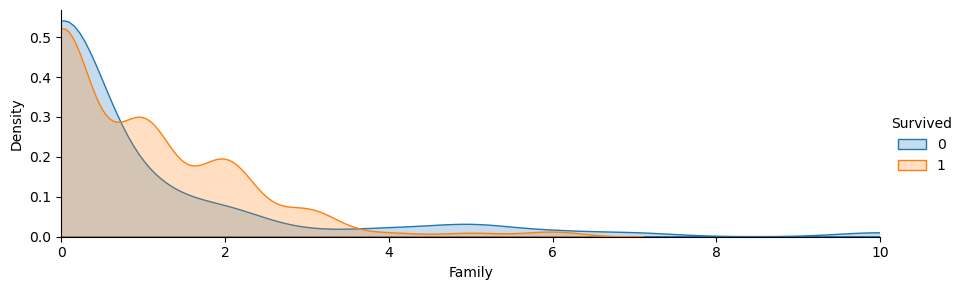

,Survived
Family,
0,0.30
1,0.55
2,0.58
3,0.72
4,0.20
5,0.14
6,0.33
7,0.00
10,0.00


In [102]:
train['Family'] = train['SibSp'] + train['Parch']

import matplotlib.pyplot as plt
import seaborn as sns

facet = sns.FacetGrid(train, hue='Survived',aspect=3)
facet.map(sns.kdeplot,'Family', fill=True)
facet.set(xlim=(0, train['Family'].max()))
facet.add_legend()
plt.show()

# Family : 혼자보다는 가족이 있는 편이 생존율이 높음
train[['Family', 'Survived']].groupby(['Family']).mean().round(2)


In [103]:
# Embarked -> 연관성 높아 보이지 않음
train[['Embarked', 'Survived']].groupby(['Embarked']).mean().round(2)

,Survived
Embarked,
C,0.55
Q,0.39
S,0.34


In [104]:
# 학습 데이터 선정 및 수정 (Pclass, Sex->SexIndex, Age->AgeGroup, Family, Fair->FairGroup) 

train['Age'].fillna(train['Age'].mean(axis=0), inplace=True)

# AgeGroup
ranges=[0,16,26,36,62,100]
labels=[0,1,2,3,4]
train["AgeGroup"] = pd.cut(train['Age'], ranges, right=False, labels=labels)

# FareGroup
ranges=[0,17,30,100,1000]
labels=[0,1,2,3]
train["FareGroup"]=pd.cut(train['Fare'], ranges ,right=False, labels=labels)

# SexIndex
train['SexIndex'] = train['Sex'].apply(lambda x:1 if (x=='female') else 0)

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,AgeGroup,FareGroup,SexIndex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,3,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,2,0,0


In [123]:
trn_data = train.loc[:790, ['Pclass','SexIndex','AgeGroup','FareGroup','Family']]
tst_data = train.loc[791:, ['Pclass','SexIndex','AgeGroup','FareGroup','Family']]

trn_lbl = train.loc[:790, 'Survived']
tst_lbl = train.loc[791:, 'Survived']

# one-hot encoding
from keras.utils import to_categorical
trn_lbl1 = to_categorical(trn_lbl)
tst_lbl1 = to_categorical(tst_lbl)

# importing Keras models and layers
from keras import models
from keras import layers

# creating sequential model
nnet = models.Sequential()

# adding a hidden layer
nnet.add(layers.Dense(64, activation="relu", input_shape=(5,)))

# adding a hidden layer
nnet.add(layers.Dense(32, activation="relu"))

# adding an output layer
nnet.add(layers.Dense(2, activation="softmax"))

nnet.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                384       
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2530 (9.88 KB)


Trainable params: 2530 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
import tensorflow as tf

nnet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

res = nnet.fit(trn_data, trn_lbl1, epochs=10, batch_size=50, validation_data=(tst_data, tst_lbl1))

Epoch 1/10
16/16 [==============================] - 2s 35ms/step - loss: 0.7001 - accuracy: 0.4968 - val_loss: 0.5843 - val_accuracy: 0.7300
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5978 - accuracy: 0.6903 - val_loss: 0.5165 - val_accuracy: 0.7500
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 0.5500 - accuracy: 0.7155 - val_loss: 0.4729 - val_accuracy: 0.7500
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5130 - accuracy: 0.7307 - val_loss: 0.4425 - val_accuracy: 0.7900
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 0.4778 - accuracy: 0.7838 - val_loss: 0.4241 - val_accuracy: 0.8200
Epoch 6/10
16/16 [==============================] - 0s 6ms/step - loss: 0.4588 - accuracy: 0.7977 - val_loss: 0.4096 - val_accuracy: 0.8100
Epoch 7/10
16/16 [==============================] - 0s 8ms/step - loss: 0.4444 - accuracy: 0.8003 - val_loss: 0.4010 - val_accuracy: 0.8100
Epoch 8/10
16/16 [=

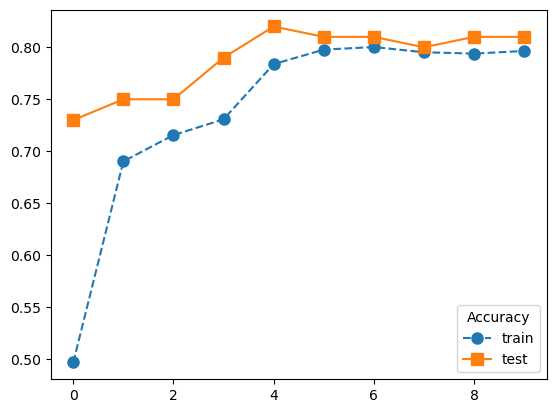

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

resdf = pd.DataFrame.from_dict(res.history)
plt.plot(resdf.accuracy, marker="o", markersize=8, ls="--", label="train")
plt.plot(resdf.val_accuracy, marker="s", markersize=8, label="test")
plt.legend(loc="lower right", title="Accuracy")
plt.show()

In [149]:
test = pd.read_csv('test.csv')

test['Family'] = test['SibSp'] + test['Parch']

test['Age'].fillna(test['Age'].mean(axis=0), inplace=True)

# AgeGroup
ranges=[0,16,26,36,62,100]
labels=[0,1,2,3,4]
test['AgeGroup'] = pd.cut(test['Age'], ranges, right=False, labels=labels)

# FareGroup
ranges=[0,17,30,100,1000]
labels=[0,1,2,3]
test['FareGroup']=pd.cut(test['Fare'], ranges ,right=False, labels=labels)

# SexIndex
test['SexIndex'] = test['Sex'].apply(lambda x:1 if (x=='female') else 0)

pred_data = test[['Pclass','SexIndex','AgeGroup','FareGroup','Family']]

import numpy as np
 
pred_lbl = np.argmax(nnet.predict(pred_data), axis=-1)

submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived': pred_lbl})  
submission.to_csv('submission.csv',index=False)

14/14 [==============================] - 0s 2ms/step


c:\Users\witty\anaconda3\envs\mylab\Lib\site-packages\pandas\core\arrays\base.py:485: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


In [151]:
submissionfile = pd.read_csv('submission.csv')
submissionfile.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
